# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [ ]:
!pip install seaborn
import seaborn as sns

penguins = sns.load_dataset("penguins")

print(penguins.head())
import pandas as pd

penguins_dummies = pd.get_dummies(penguins, columns=['species', 'island'], drop_first=True)

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Confusion Matrix for kNN (K=3):
[[28  1  1]
 [ 8  6  0]
 [ 3  0 22]]

Overall Accuracy for kNN (K=3): 0.8116

Classification Report for kNN (K=3):
              precision    recall  f1-score   support

      Adelie       0.72      0.93      0.81        30
   Chinstrap       0.86      0.43      0.57        14
      Gentoo       0.96      0.88      0.92        25

    accuracy                           0.81        69
   macro avg       0.84      0.75      0.77        69
weighted avg       0.83      0.81      0.80        69


Confusion Matrix for kNN (K=5):
[[29  1  0]
 [12  2  0]
 [ 2  0 23]]

Overall Accuracy for kNN (K=5): 0.7826

Classification Report for kNN (K=5):
              precision    recall  f1-score   support

      Adelie       0.67      0.97      0.79        30
   Chinstrap       0.67      0.14      0.24        14
      Gentoo       1.00      0.92      0.96        25

    accuracy                           0.78        69
   macro avg       0.78      0.68      0.66        

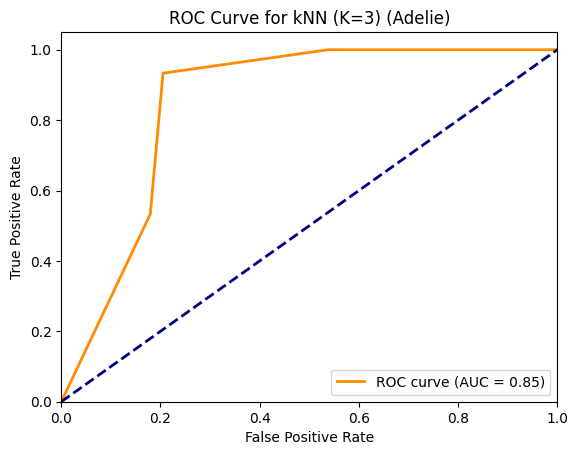

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

X = penguins.drop('species', axis=1)
y = penguins['species']


encoder = OneHotEncoder(sparse=False, drop='first')
X_encoded = pd.DataFrame(encoder.fit_transform(X.select_dtypes(include=['object'])))
X_encoded.columns = encoder.get_feature_names_out(X.select_dtypes(include=['object']).columns)

X = pd.concat([X, X_encoded], axis=1)
X.drop(X.select_dtypes(include=['object']).columns, axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numeric_cols = X.select_dtypes(include=['float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)

X_train_imputed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=numeric_cols.append(categorical_cols))
X_test_imputed = pd.DataFrame(preprocessor.transform(X_test), columns=numeric_cols.append(categorical_cols))


def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)


    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {model_name}:\n{cm}")


    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nOverall Accuracy for {model_name}: {accuracy:.4f}")

    classification_rep = classification_report(y_test, y_pred)
    print(f"\nClassification Report for {model_name}:\n{classification_rep}")

    return y_pred

def plot_roc_curve(y_test, y_pred, model_name):

    species_of_interest = 'Adelie'


    y_true_binary = (y_test == species_of_interest).astype(int)
    y_pred_proba = y_pred[:, 0]
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} ({species_of_interest})')
    plt.legend(loc="lower right")
    plt.show()

knn_model_3 = KNeighborsClassifier(n_neighbors=3)
knn_model_3.fit(X_train_imputed, y_train)

y_pred_knn_3 = evaluate_model(knn_model_3, X_test_imputed, y_test, 'kNN (K=3)')

knn_model_5 = KNeighborsClassifier(n_neighbors=5)
knn_model_5.fit(X_train_imputed, y_train)

y_pred_knn_5 = evaluate_model(knn_model_5, X_test_imputed, y_test, 'kNN (K=5)')

tree_model_3 = DecisionTreeClassifier(max_depth=3)
tree_model_3.fit(X_train_imputed, y_train)

y_pred_tree_3 = evaluate_model(tree_model_3, X_test_imputed, y_test, 'Decision Tree (Depth=3)')

tree_model_5 = DecisionTreeClassifier(max_depth=5)
tree_model_5.fit(X_train_imputed, y_train)

y_pred_tree_5 = evaluate_model(tree_model_5, X_test_imputed, y_test, 'Decision Tree (Depth=5)')

plot_roc_curve(y_test, knn_model_3.predict_proba(X_test_imputed), 'kNN (K=3)')
